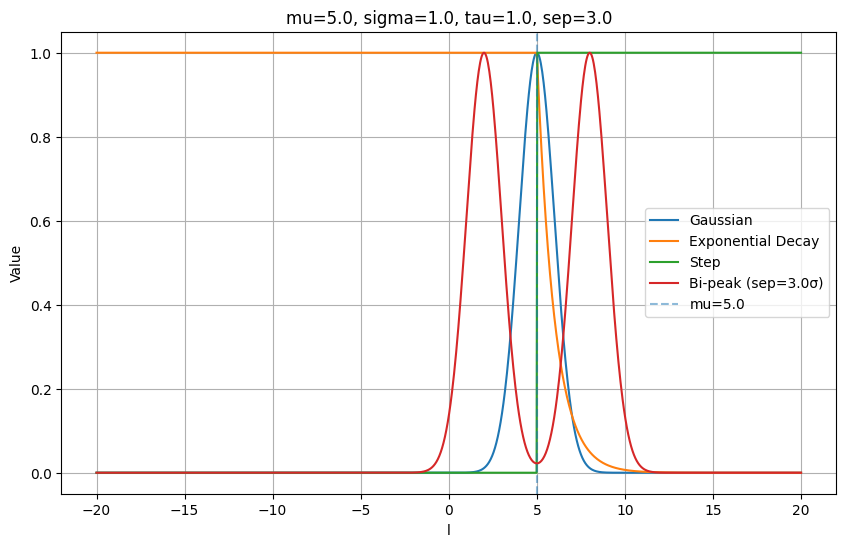

In [8]:
###展示峰的形态
import torch
import matplotlib.pyplot as plt

def _build_bank(l, mu, sigma, tau, sep=3.0):
    gauss  = torch.exp(-0.5 * ((l - mu) / (sigma + 1e-9)).pow(2))
    expdc  = torch.exp(-(torch.relu(l - mu)) / (tau + 1e-9))
    step   = (l >= mu).float()
    # 让双峰的两个中心在 μ ± (sep * σ)
    c = sep * (sigma + 1e-9)
    bipeak = torch.exp(-0.5 * ((l - (mu - c)) / (sigma + 1e-9)).pow(2)) + \
             torch.exp(-0.5 * ((l - (mu + c)) / (sigma + 1e-9)).pow(2))
    return torch.stack([gauss, expdc, step, bipeak], dim=-1)

def plot_functions(mu=5.0, sigma=1.0, tau=1.0, sep=3.0, l_range=(-20, 20), n_points=1000):
    l = torch.linspace(l_range[0], l_range[1], n_points)
    bank = _build_bank(l, mu, sigma, tau, sep=sep).numpy()

    labels = ["Gaussian", "Exponential Decay", "Step", f"Bi-peak (sep={sep}σ)"]
    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.plot(l, bank[:, i], label=labels[i])
    plt.axvline(mu, linestyle='--', alpha=0.5, label=f"mu={mu}")
    plt.legend()
    plt.title(f"mu={mu}, sigma={sigma}, tau={tau}, sep={sep}")
    plt.xlabel("l")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# 示例：sep=3.0 时会明显出现两个峰
plot_functions(mu=5.0, sigma=1.0, tau=1.0, sep=3.0)


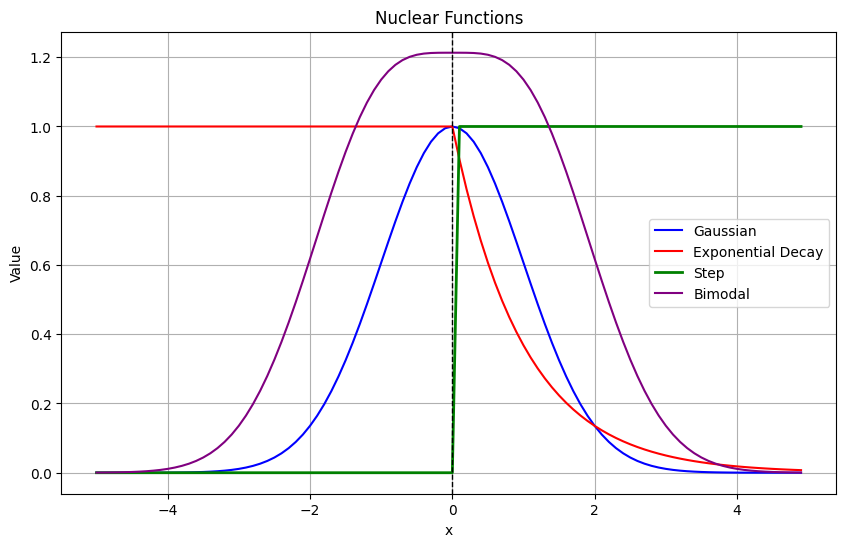

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
mu = 0.0      # 均值/中心位置
sigma = 1.0   # 标准差/宽度
tau = 1.0     # 衰减率
epsilon = 1e-9  # 避免除零的小常数

# 生成 x 轴数据 (范围从 -5 到 5，步长 0.1)
x = np.arange(-5.0, 5.0, 0.1)

# 定义四个核函数
gauss = np.exp(-0.5 * ((x - mu) / (sigma + epsilon))**2)
expdc = np.exp(-np.maximum(0, x - mu) / (tau + epsilon))
step = (x >= mu).astype(float)
bipeak = np.exp(-0.5 * ((x - (mu - sigma)) / (sigma + epsilon))**2) + np.exp(-0.5 * ((x - (mu + sigma)) / (sigma + epsilon))**2)

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x, gauss, label='Gaussian', color='blue')
plt.plot(x, expdc, label='Exponential Decay', color='red')
plt.plot(x, step, label='Step', color='green', linewidth=2)
plt.plot(x, bipeak, label='Bimodal', color='purple')

# 添加标题和标签
plt.title('Nuclear Functions')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.axvline(x=mu, color='black', linestyle='--', linewidth=1)  # 标记 mu 位置

# 显示图形
plt.show()

In [4]:
import numpy as np

def sinkhorn(p, q, C, epsilon, max_iters=1000, tol=1e-9):
    """
    Sinkhorn算法求解熵正则化最优传输问题

    参数：
    - p: 源分布，形状 (m,)
    - q: 目标分布，形状 (n,)
    - C: 成本矩阵，形状 (m, n)
    - epsilon: 正则化参数
    - max_iters: 最大迭代次数，默认为1000
    - tol: 收敛容差，默认为1e-9

    返回：
    - P: 传输计划，形状 (m, n)
    """
    assert len(p) == C.shape[0], "p与C的行维度不匹配"
    assert len(q) == C.shape[1], "q与C的列维度不匹配"
    assert abs(np.sum(p) - np.sum(q)) < 1e-10, "p和q的总质量必须相等"

    # 计算内核矩阵
    K = np.exp(-C / epsilon)
    
    # 初始化缩放向量
    u = np.ones(len(p))
    v = np.ones(len(q))
    
    for _ in range(max_iters):
        u_old = u.copy()
        # 更新 u: 强制行边际
        u = p / (K @ v)
        # 更新 v: 强制列边际
        v = q / (K.T @ u)
        # 检查收敛
        if np.max(np.abs(u - u_old)) < tol:
            break
    
    # 计算传输计划
    P = np.diag(u) @ K @ np.diag(v)
    return P

# 示例用法
p = np.array([0.2, 0.3, 0.5])
q = np.array([0.1, 0.4, 0.5])
C = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
epsilon = 0.1

P = sinkhorn(p, q, C, epsilon)
print("传输计划 P:\n", P)
print("行和:", np.sum(P, axis=1))  # 应接近 p
print("列和:", np.sum(P, axis=0))  # 应接近 q

传输计划 P:
 [[0.02 0.08 0.1 ]
 [0.03 0.12 0.15]
 [0.05 0.2  0.25]]
行和: [0.2 0.3 0.5]
列和: [0.1 0.4 0.5]


(10, 4)
(10, 4)


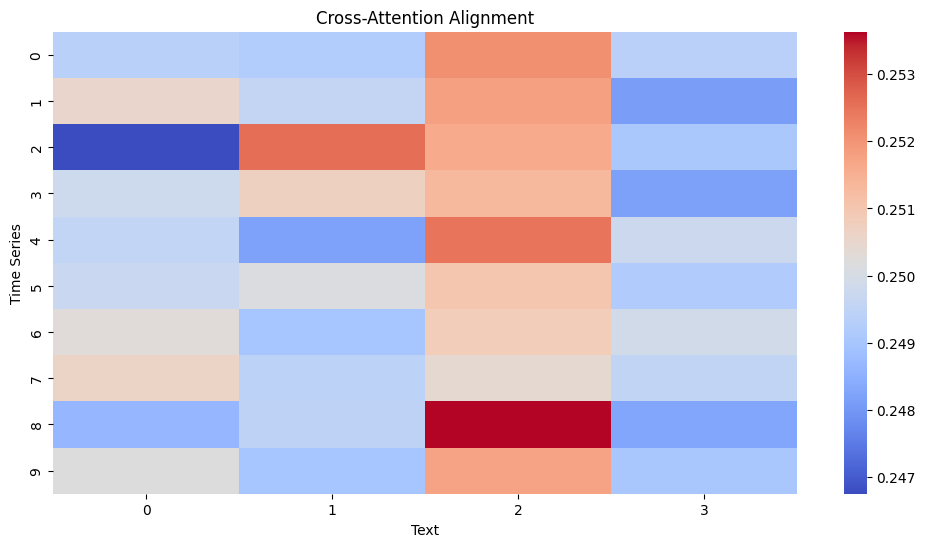

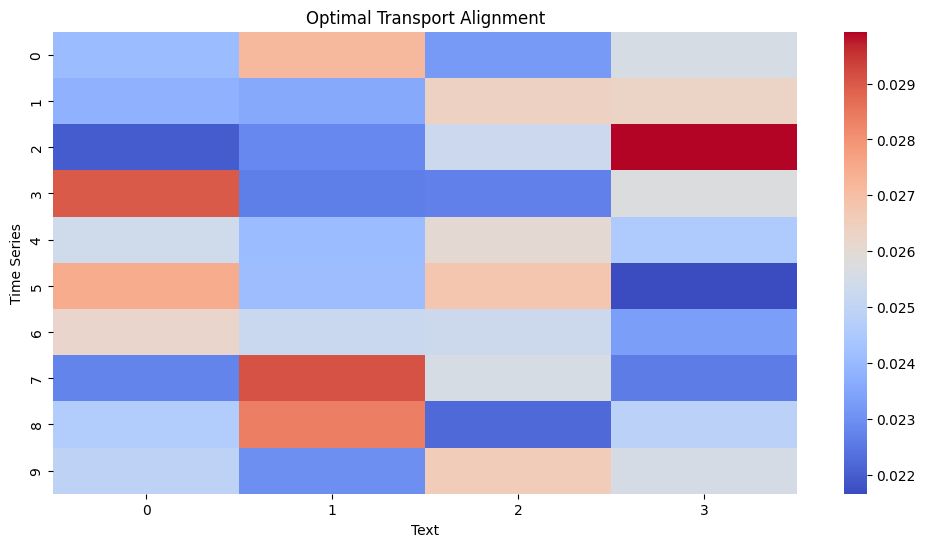

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Cross-Attention 实现
# class CrossAttention(nn.Module):
#     def __init__(self, embed_dim, num_heads):
#         super(CrossAttention, self).__init__()
#         self.attn = nn.MultiheadAttention(embed_dim, num_heads)
    
#     def forward(self, x_enc, x_text):
#         # x_enc: [B, N, d_model], x_text: [B, T, d_model]
#         # Transpose to [T, B, d_model] for MultiheadAttention
#         x_text = x_text.transpose(0, 1)  # [T, B, d_model]
#         x_enc = x_enc.transpose(0, 1)  # [N, B, d_model]
        
#         # Cross attention
#         attn_output, _ = self.attn(x_enc, x_text, x_text)
        
#         # Transpose back to [B, N, d_model]
#         return attn_output.transpose(0, 1)

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x_enc, x_text):
        # x_enc: [B, N, d_model], x_text: [B, T, d_model]
        # Transpose to [T, B, d_model] for MultiheadAttention
        x_text = x_text.transpose(0, 1)  # [T, B, d_model]
        x_enc = x_enc.transpose(0, 1)  # [N, B, d_model]
        
        # Cross attention
        attn_output, attn_weights = self.attn(x_enc, x_text, x_text)
        
        # Return the attention weights (shape: [B, num_heads, T, N])
        return attn_weights.transpose(0, 1)  # [B, num_heads, T, N]

    
# 最优传输（Optimal Transport, OT）实现
def sinkhorn(C, r, c, eps=0.1, iters=50):
    B, K, H = C.shape
    Kmat = torch.exp(-C / eps)  # Gibbs kernel

    u = torch.ones_like(r)
    v = torch.ones_like(c)
    
    for _ in range(iters):
        Kv = torch.bmm(Kmat, v.unsqueeze(-1)).squeeze(-1).clamp_min(1e-9)   # [B,K]
        u = r / Kv
        Ku = torch.bmm(Kmat.transpose(1,2), u.unsqueeze(-1)).squeeze(-1).clamp_min(1e-9)  # [B,H]
        v = c / Ku
    
    Pi = u.unsqueeze(-1) * Kmat * v.unsqueeze(1)  # Optimal transport plan [B, K, H]
    return Pi

# 对比 Cross-Attention 和 最优传输
def compare_alignments(batch_size, seq_len, txt_len, embed_dim, num_heads, alpha=1.0, beta=0.02, eps=0.1, iters=50):
    # 创建随机数据
    x_enc = torch.rand(batch_size, seq_len, embed_dim)  # 时间序列嵌入 [B, N, d_model]
    x_text = torch.rand(batch_size, txt_len, embed_dim)  # 文本嵌入 [B, T, d_model]
    
    # Cross-Attention 对齐
    cross_attention_model = CrossAttention(embed_dim, num_heads)
    cross_attention_output = cross_attention_model(x_enc, x_text)
    
    # 计算最优传输代价矩阵（这里使用余弦相似度作为代价）
    k = F.normalize(x_enc, dim=-1)  # [B, N, d_model]
    f = F.normalize(x_text, dim=-1)  # [B, T, d_model]
    
    # 计算余弦相似度
    cos = 1 - torch.einsum('bnd,btd->bnt', k, f)  # [B, N, T]
    
    # 行边际：每个时间片段的质量（假设均匀分布）
    r = torch.full((batch_size, seq_len), 1.0 / seq_len, device=k.device, dtype=k.dtype)  # [B, N]
    c = torch.full((batch_size, txt_len), 1.0 / txt_len, device=f.device, dtype=f.dtype)  # [B, T]
    
    # 计算最优传输计划 Pi
    Pi = sinkhorn(cos, r, c, eps, iters)
    
    # 返回对比结果
    return cross_attention_output, Pi

# 可视化对齐结果的函数
def visualize_alignment(cross_attention_output, ot_output, batch_size, seq_len, txt_len):
    # Cross-Attention 的热力图（每个核与每个时间步的对齐）
    cross_attention_attention_map = cross_attention_output.mean(dim=1).squeeze(0).cpu().detach().numpy()  # [T, N]

    print(cross_attention_attention_map.shape)  # 应该是 [N, N]
    # 最优传输的热力图
    ot_output_map = ot_output.mean(dim=0).cpu().detach().numpy()  # [K, H]（平均每个批次）
    print(ot_output_map.shape)  

    # 可视化：Cross-Attention 热力图
    plt.figure(figsize=(12, 6))
    sns.heatmap(cross_attention_attention_map, cmap='coolwarm', annot=False, xticklabels=range(txt_len), yticklabels=range(seq_len))
    plt.title("Cross-Attention Alignment")
    plt.xlabel("Text")
    plt.ylabel("Time Series")
    plt.show()

    # 可视化：最优传输热力图
    plt.figure(figsize=(12, 6))
    sns.heatmap(ot_output_map, cmap='coolwarm', annot=False, xticklabels=range(txt_len), yticklabels=range(seq_len))
    plt.title("Optimal Transport Alignment")
    plt.xlabel("Text")
    plt.ylabel("Time Series")
    plt.show()

# 设置参数
batch_size = 16
seq_len = 10
txt_len = 4
embed_dim = 32
num_heads = 4

# 进行对比并可视化
cross_attention_output, ot_output = compare_alignments(batch_size, seq_len, txt_len, embed_dim, num_heads)
visualize_alignment(cross_attention_output, ot_output, batch_size, seq_len, txt_len)


In [10]:
import numpy as np
import pandas as pd
import random

# 随机种子以确保可重复性
np.random.seed(42)
random.seed(42)

# 生成文本数据（未来天数、趋势类型、趋势速率）
def generate_text():
    future_days = random.randint(1, 7)  # 1到7天之间
    trend = random.choice(["上升", "下降"])
    rate = random.choice(["持续", "迅速"])
    return f"未来 {future_days} 天{rate}{trend}"

# 生成对应的数值（例如，未来天数内的总变化量）
def generate_value(text,value):
    # 提取文本中的信息
    future_days = int(text.split("未来")[1].split("天")[0])
    trend = "上升" if "上升" in text else "下降"
    rate = "迅速" if "迅速" in text else "持续"
    
    # 基于文本生成变化幅度
    if trend == "上升":
        if rate == "持续":
            value_change = value + random.uniform(0.1, 0.5) * future_days  # 持续上升的变化量
        else:
            value_change = value + random.uniform(1.0, 3.0) * future_days  # 迅速上升的变化量
    else:  # 下降
        if rate == "持续":
            value_change = value -random.uniform(0.1, 0.5) * future_days  # 持续下降的变化量
        else:
            value_change = value  -random.uniform(1.0, 3.0) * future_days  # 迅速下降的变化量
    
    return round(value_change, 2)  # 保留两位小数


# 生成数据集
def generate_dataset(num_samples=10000):
    data = []
    value = 0
    for _ in range(num_samples):
        # 生成文本
        text = generate_text()
        # 生成对应的数值
        value = generate_value(text,value)
        # 将文本和数值放入数据集
        data.append((text, value))
    
    return data

# 构建数据集
dataset = generate_dataset()

# 将数据存储为DataFrame
texts = [item[0] for item in dataset]
values = [item[1] for item in dataset]
df = pd.DataFrame({
    "text": texts,
    "value": values
})

# 查看前几个样本
print(df.head())

# 如果需要保存为csv
df.to_csv('generated_time_series_dataset.csv', index=False)


         text  value
0  未来 6 天持续上升   2.38
1  未来 2 天持续上升   3.17
2  未来 6 天迅速上升   9.55
3  未来 1 天持续上升   9.85
4  未来 1 天迅速上升  11.29


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

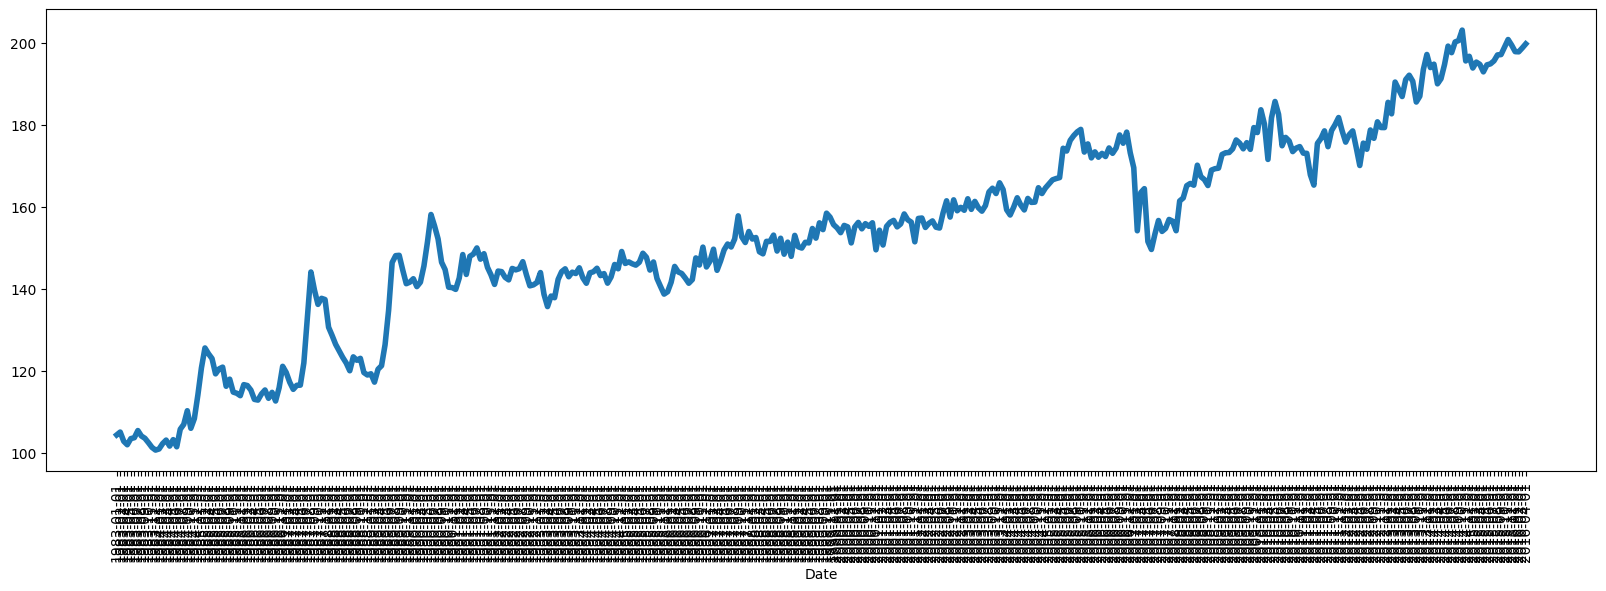

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('/home/ghl/MMTS/TaTS_TICAL/data/Agriculture.csv')
####绘制OT列的
data = df['OT'].values
df = df.iloc[0:400]

plt.figure(figsize=(20,6))

plt.plot(df["date"], df["prior_history_avg"], label="avg",linewidth = 4)
plt.xlabel("Date")
plt.xticks(rotation=90)


Index(['OT', 'Date', 'start_date', 'date', 'end_date', 'prior_history_avg',
       'prior_history_std', 'fact', 'preds'],
      dtype='object')


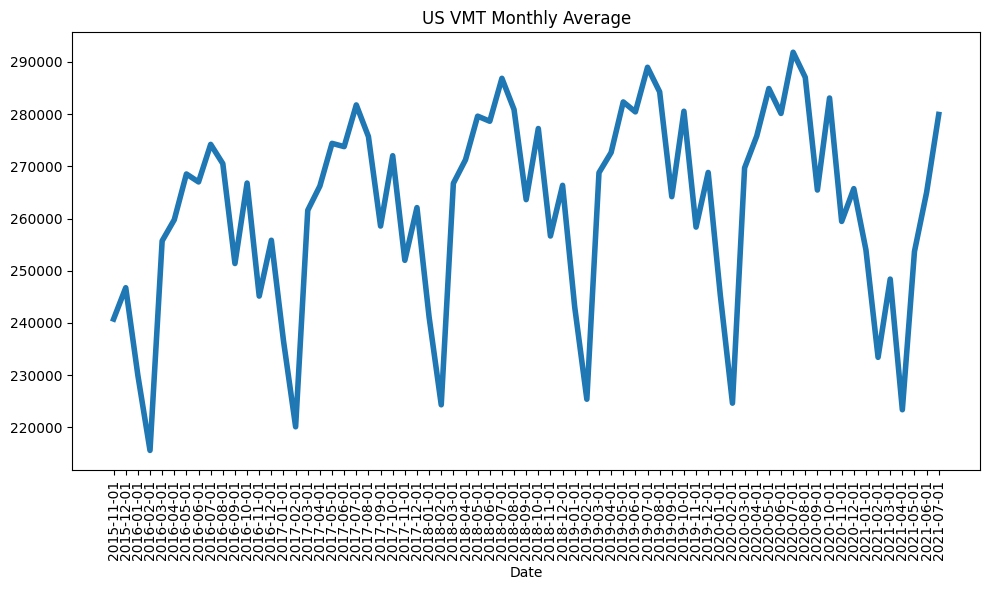

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv("/home/ghl/MMTS/TaTS_TICAL/data/Traffic.csv")

# 查看列名，确保有 'avg'
print(df.columns)
df = df.iloc[430:499]
# 绘制 avg 列
plt.figure(figsize=(10,6))
plt.plot(df["date"], df["prior_history_avg"], label="avg",linewidth = 4)
plt.xlabel("Date")
# plt.ylabel("Average Value")
plt.title("US VMT Monthly Average")
# plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [18]:
# -*- coding: utf-8 -*-
import os, re
import pandas as pd
from datetime import datetime
from typing import List

# ========= 配置 =========
INPUT_FILE = "/home/ghl/MMTS/TaTS_TICAL/data/Energy.csv"
OUTPUT_FILE = "/home/ghl/MMTS/TaTS_TICAL/data/Energy_text.csv"

# ========= 正则 =========
SENT_SPLIT_RE = re.compile(r'(?<=[\.\!\?。！？])\s+')
FUTURE_PATTERNS: List[re.Pattern] = [
    re.compile(r"\b(in|over|within)\s+the\s+(next|coming)\s+\d+\s+(days|weeks|months|years)\b", re.I),
    re.compile(r"\b(is|are|be)\s+(expected|likely|projected)\s+to\b", re.I),
    re.compile(r"\bwill\b", re.I),
    re.compile(r"\bmay|might|could|can\b.*(lead to|result in|cause|trigger)", re.I),
]

# ========= 工具函数 =========
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return re.sub(r"\s+", " ", s.replace("\n", " ")).strip()

def split_sentences(text: str) -> List[str]:
    text = clean_text(text)
    if not text:
        return []
    parts = SENT_SPLIT_RE.split(text)
    return [p.strip() for p in parts if len(p.strip()) >= 5]

def is_inductive_event(sentence: str) -> bool:
    if not sentence:
        return False
    return any(p.search(sentence) for p in FUTURE_PATTERNS)

def normalize_time(val) -> str:
    if pd.isna(val):
        return ""
    s = str(val).strip()
    for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%Y%m%d", "%Y-%m"):
        try:
            dt = datetime.strptime(s, fmt)
            if fmt == "%Y-%m":
                dt = dt.replace(day=1)
            return dt.strftime("%Y-%m-%d")
        except:
            continue
    return s

# ========= 主流程 =========
def main():
    if not os.path.exists(INPUT_FILE):
        print(f"文件不存在: {INPUT_FILE}")
        return

    df = pd.read_csv(INPUT_FILE)
    text_col = "preds" if "preds" in df.columns else "fact"
    time_col = "date" if "date" in df.columns else "start_date"

    events = []
    for idx, row in df.iterrows():
        sentences = split_sentences(str(row.get(text_col, "")))
        anchor_time = normalize_time(row.get(time_col, ""))
        for sent in sentences:
            if is_inductive_event(sent):
                events.append({
                    "row_index": idx,
                    "anchor_time": anchor_time,
                    "event_sentence": sent,
                    "source_col": text_col
                })

    out_df = pd.DataFrame(events)
    out_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")
    print(f"提取完成，共 {len(out_df)} 条事件，已保存到 {OUTPUT_FILE}")

if __name__ == "__main__":
    main()


提取完成，共 1548 条事件，已保存到 /home/ghl/MMTS/TaTS_TICAL/data/Energy_text.csv
